### Notebook for the CCCI-derived metabolism from scRNA-Seq using `mebocost` - Mixed cell states Healthy-CTRL

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich**
- v230622

### Import required modules

In [1]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

Warning (xlmhg): Failed to import "mhg_cython" C extension.
Warning (xlmhg): Failed to import the "mhg_cython" C extension.Falling back to the pure Python implementation, which is very slow.


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                         10.2.0
adjustText                  NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
beta_ufunc                  NA
binom_ufunc                 NA
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.0
executing                   2.0.1
fastjsonschema              NA
fontTools                   4.47.0
fqdn                        NA
h5py                        3.10.0
hypergeom_ufunc             NA
idna                        3.6
ipykernel

### Read in dataset

In [3]:
mixed = sc.read_h5ad('../../data/Kdm6aKO_MEBOCOST-CMC-FB-Mye_ctl240311.raw.h5ad') 
mixed

AnnData object with n_obs × n_vars = 24354 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [4]:
mixed.obs['genotype'].cat.categories

Index(['KO', 'Sham', 'Tx', 'WT'], dtype='object')

In [5]:
adata = mixed[mixed.obs['genotype'].isin(['WT'])]
adata

View of AnnData object with n_obs × n_vars = 7184 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [6]:
adata.obs['C_scANVI'].cat.categories

Index(['CD14+Mo', 'CD69+Mo', 'DC2', 'DOCK4+aMØ', 'DOCK4+vMØ', 'FB1', 'FB2',
       'FB3', 'FB4', 'FB5', 'FB6', 'ILC', 'LYVE1+MØ1', 'LYVE1+MØ2', 'M2MØ',
       'Mast', 'MoMø', 'NK_CD16hi', 'NK_CD56hi', 'TREM2+MØ', 'gdT', 'nøMo',
       'pDC', 'proIMØ', 'vCM1', 'vCM2', 'vCM3', 'vCM4'],
      dtype='object')

- Is data raw?

In [7]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis = 0))

In [8]:
X_is_raw(adata)

True

### Infer Highly Variable Genes to speed up and improve inference

In [9]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 7184 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'

### Infer metabolic communications

- The `mebocost.conf` file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink. 

In [10]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['C_scANVI'],
                        met_est = 'mebocost',
                        config_path = './mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'mouse',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[March 11, 2024 16:26:28]: We get expression data with 7000 genes and 7184 cells.
[March 11, 2024 16:26:28]: Data Preparation Done in 0.0378 seconds


### Estimate metabolite presence

- If you just want the table of metabolic activity, you can stop here and export it as a CSV file. 

In [11]:
mebo_obj._load_config_()
mebo_obj.estimator()

[March 11, 2024 16:26:32]: Load config and read data based on given species [mouse].
[March 11, 2024 16:26:33]: Estimtate metabolite level using mebocost


In [12]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

AAACAGCCAGGCCATT-1-KDM6A_wt_11-cmc  \
HMDB0003450                            0.000000   
HMDB0003948                            3.666667   
HMDB0003712                            3.666667   
HMDB0003945                            3.666667   
HMDB0003949                            3.666667   

             AAACATGCAAACCTAT-1-KDM6A_wt_11-cmc  \
HMDB0003450                            0.000000   
HMDB0003948                            3.333333   
HMDB0003712                            3.333333   
HMDB0003945                            3.333333   
HMDB0003949                            3.333333   

             AAACATGCACACCAAC-1-KDM6A_wt_11-cmc  \
HMDB0003450                            0.000000   
HMDB0003948                            1.333333   
HMDB0003712                            1.333333   
HMDB0003945                            1.333333   
HMDB0003949                            1.333333   

             AAACCAACAAACAACA-1-KDM6A_wt_11-cmc  \
HMDB0003450                                 0.0   
HMDB0003948                                 3.0   
HMDB0003712                                 3.0   
HMDB0003945                                 3.0   
HMDB0003949                                 3.0   

             AAACCAACAGTTTCTC-1-KDM6A_wt_11-cmc  \
HMDB0003450                            0.000000   
HMDB0003948                            0.333333   
HMDB0003712                            0.333333   
HMDB0003945                            0.333333   
HMDB0003949                            0.333333   

             AAACCGAAGGTGAGAC-1-KDM6A_wt_11-cmc  \
HMDB0003450                            0.000000   
HMDB0003948                            1.666667   
HMDB0003712                            1.666667   
HMDB0003945                            1.666667   
HMDB0003949                            1.666667   

             AAACCGAAGTCATTAG-1-KDM6A_wt_11-cmc  \
HMDB0003450                            0.000000   
HMDB0003948                            1.333333   
HMDB0003712                            1.333333   
HMDB0003945                            1.333333   
HMDB0003949                            1.333333   

             AAACCGCGTTAAGTGT-1-KDM6A_wt_11-cmc  \
HMDB0003450                                 0.0   
HMDB0003948                                 2.0   
HMDB0003712                                 2.0   
HMDB0003945                                 2.0   
HMDB0003949                                 2.0   

             AAACCGCGTTACCGGG-1-KDM6A_wt_11-cmc  \
HMDB0003450                                 0.0   
HMDB0003948                                 2.0   
HMDB0003712                                 2.0   
HMDB0003945                                 2.0   
HMDB0003949                                 2.0   

             AAACGCGCAGTATGTT-1-KDM6A_wt_11-cmc  ...  \
HMDB0003450                            0.000000  ...   
HMDB0003948                            0.666667  ...   
HMDB0003712                            0.666667  ...   
HMDB0003945                            0.666667  ...   
HMDB0003949                            0.666667  ...   

             TTGGTGAGTCCGGTTC-1-KDM6A_wt_40-myeloid  \
HMDB0003450                                0.000000   
HMDB0003948                                0.333333   
HMDB0003712                                0.333333   
HMDB0003945                                0.333333   
HMDB0003949                                0.333333   

             TTGTCCCAGTTAACCA-1-KDM6A_wt_40-myeloid  \
HMDB0003450                                     0.0   
HMDB0003948                                     0.0   
HMDB0003712                                     0.0   
HMDB0003945                                     0.0   
HMDB0003949                                     0.0   

             TTGTCCGGTTTCCGGC-1-KDM6A_wt_40-myeloid  \
HMDB0003450                                     0.0   
HMDB0003948                                     0.0   
HMDB0003712                                     0.0   
HMDB0003945                    

In [13]:
met_mat.shape

(379, 7184)

### MEBOCOST cell-cell communication inference

In [14]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[March 11, 2024 16:26:40]: Load config and read data based on given species [mouse].
[March 11, 2024 16:26:41]: Estimtate metabolite level using mebocost
[March 11, 2024 16:26:47]: Infer communications
[March 11, 2024 16:26:47]: Sensor type used ['Receptor', 'Transporter', 'Nuclear Receptor']
[March 11, 2024 16:26:47]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[March 11, 2024 16:26:47]: met_sensor: (109, 8)
[March 11, 2024 16:26:47]: avg_exp: (634, 28) for (gene, cell) of needed
[March 11, 2024 16:26:47]: avg_met: (379, 28) for (metabolite, cell) of needed
[March 11, 2024 16:26:47]: shuffling 1000 times for generating backgroud
[March 11, 2024 16:26:50]: take exp and met avg for shuffling
[March 11, 2024 16:26:59]: thread: 4
[March 11, 2024 16:26:59]: Cd36 ~ HMDB0003276
[March 11, 2024 16:27:00]: Normalizing Cluster Mean and Calculating Communication Score
[March 11, 2024 16:27:00]: Ffar4 ~ HMDB0002183
[March 11, 2024 16:27:00]: Normalizing Cluster Mean and Calc

In [15]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 1.0
metabolite_presence cutoff: 0.3333333333333333


### Visualise MEBOCOST prediction

- Summary of the number of communication events

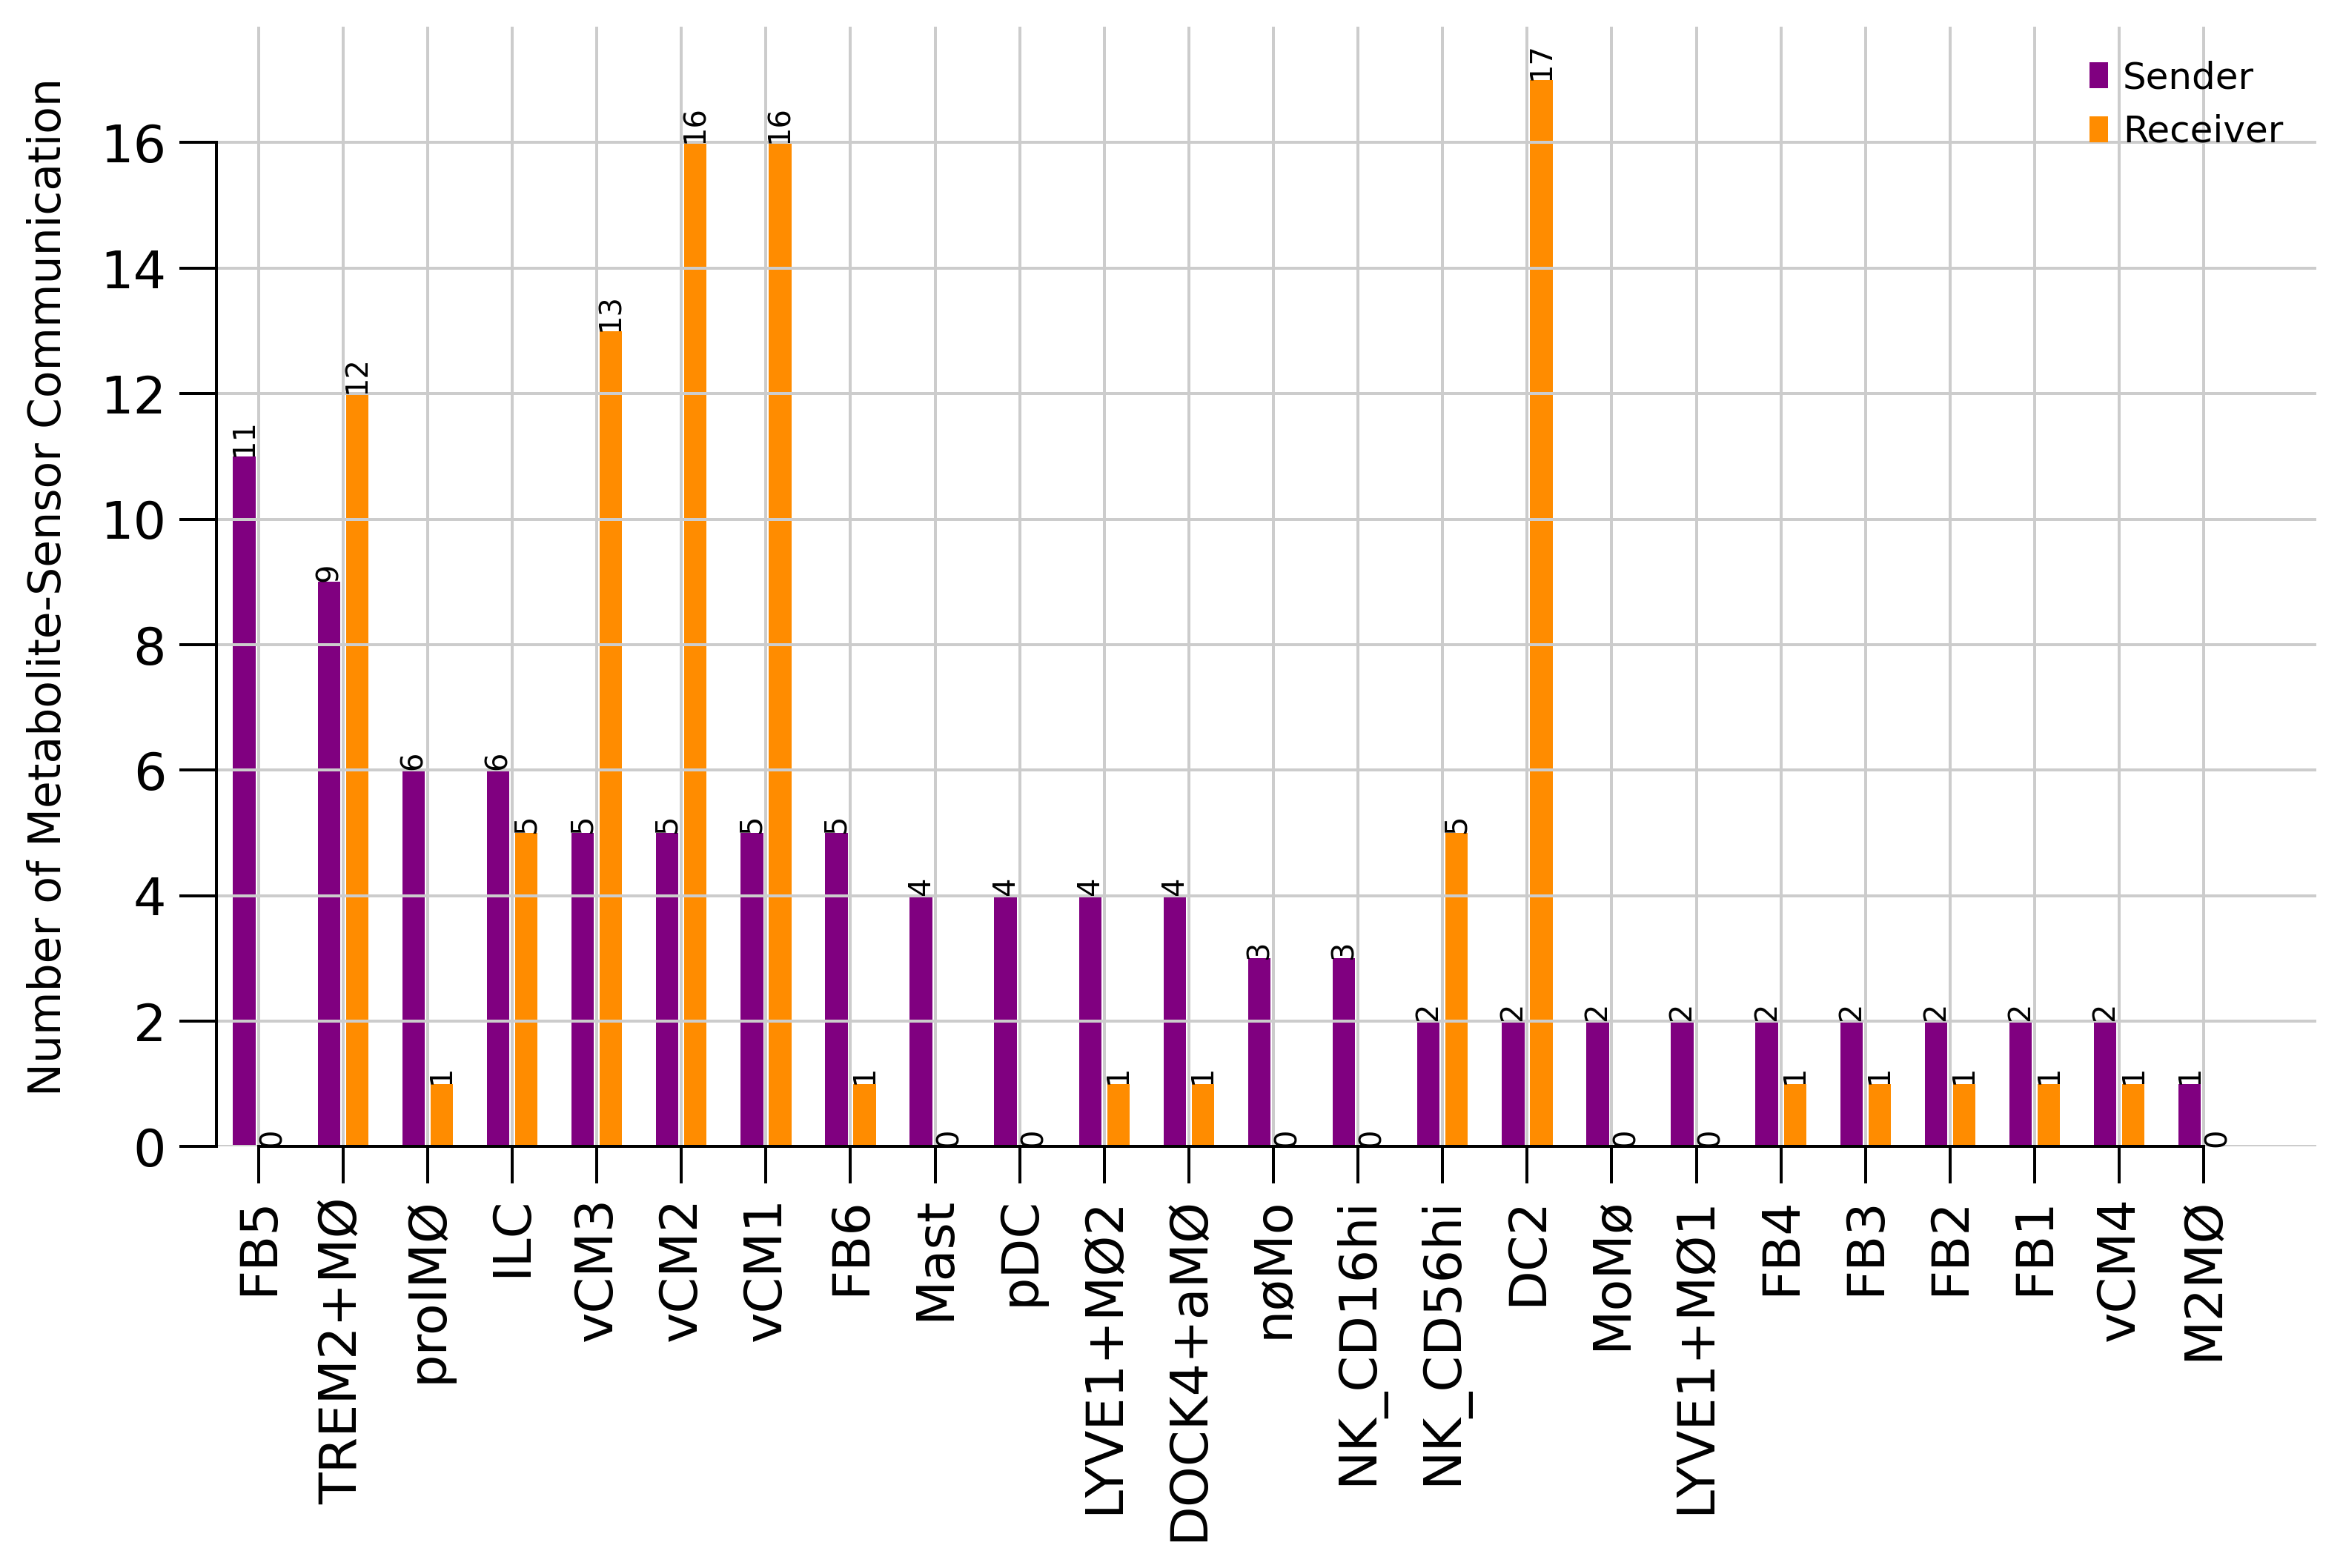

In [16]:
mebo_obj.eventnum_bar(
                    sender_focus = [],
                    metabolite_focus = [],
                    sensor_focus = [],
                    receiver_focus = [],
                    and_or = 'and',
                    pval_method = 'permutation_test_fdr',
                    pval_cutoff = 0.05,
                    comm_score_col = 'Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize = 'auto',
                    save = None,
                    show_plot = True,
                    show_num = True,
                    include = ['sender-receiver'],
                    group_by_cell = True,
                    colorcmap = 'tab20',
                    return_fig = False
                )

- Showing the communication between sender and receiver in a dot plot

[March 11, 2024 16:34:15]: plot dot plot to show communication in cell type level


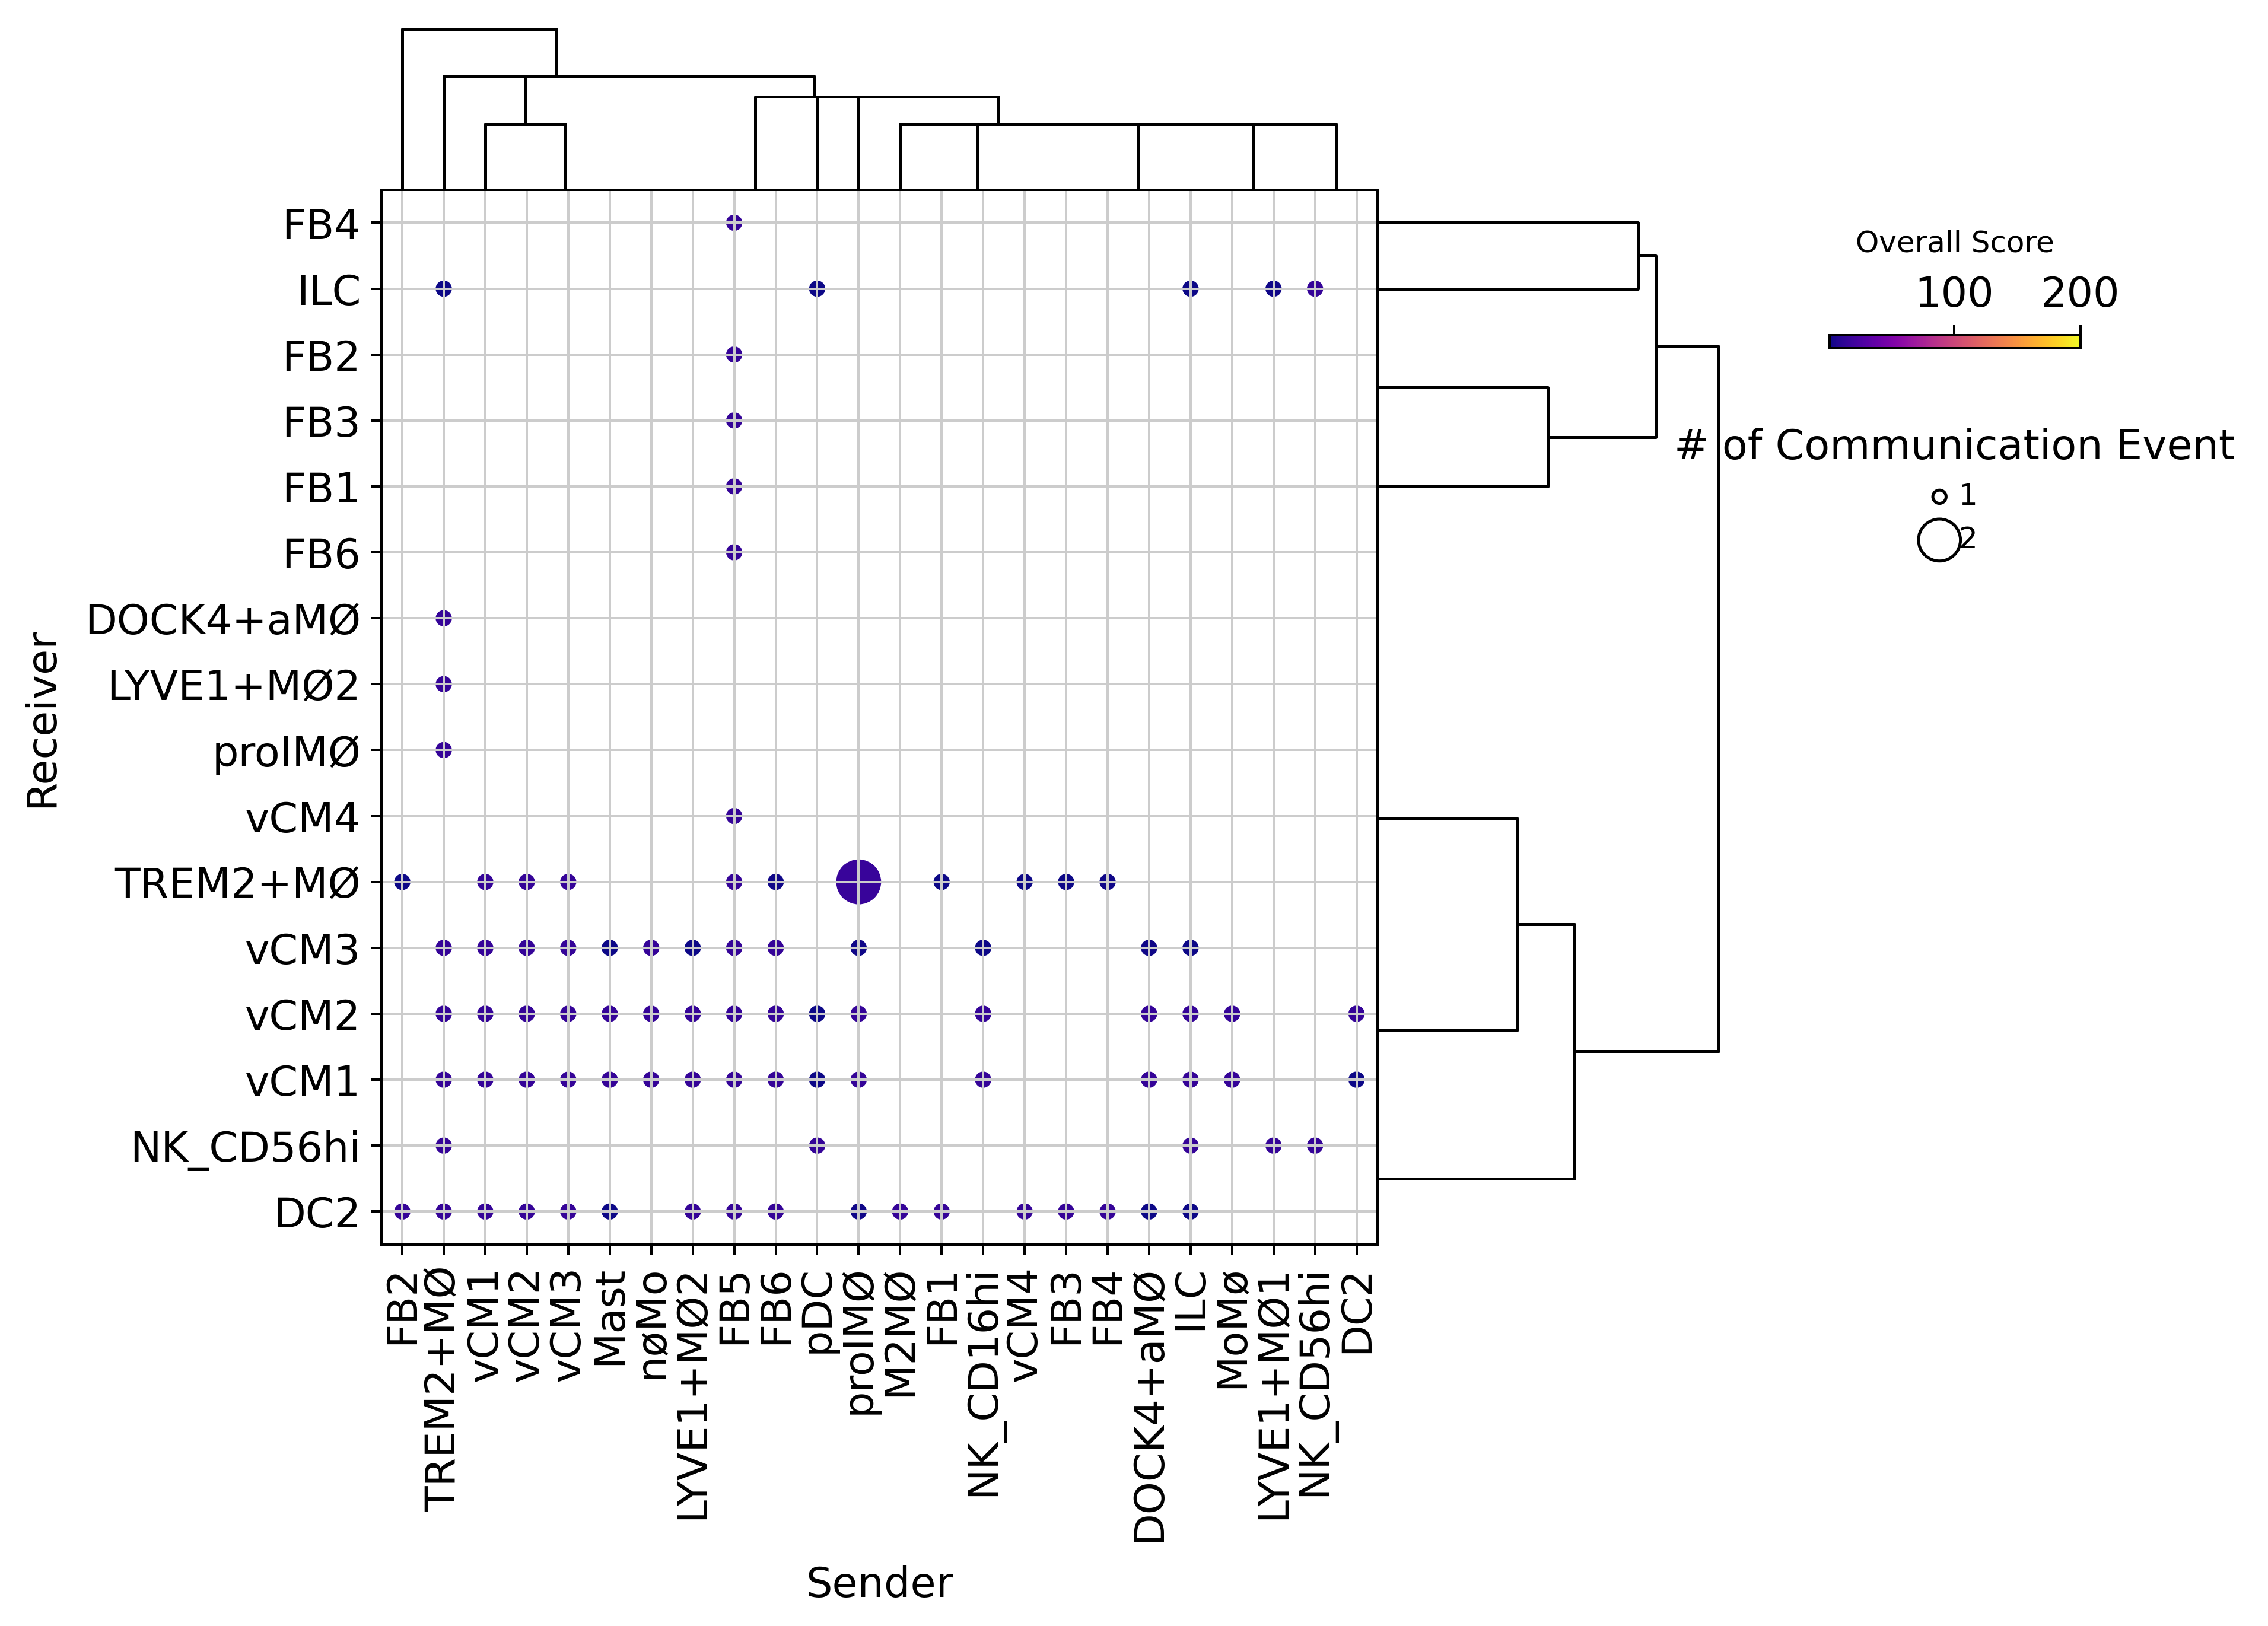

In [17]:
mebo_obj.count_dot_plot(
                        pval_method = 'permutation_test_fdr',
                        pval_cutoff = 0.05,
                        cmap = 'plasma',
                        figsize = 'auto',
                        save = None,
                        dot_size_norm = (20, 200),
                        dot_color_vmin = None,
                        dot_color_vmax = 200,
                        show_plot = True,
                        comm_score_col = 'Commu_Score',
                        comm_score_cutoff = 0,
                        return_fig = False
                    )

- Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

[March 11, 2024 16:35:11]: plot heatmap for significant result


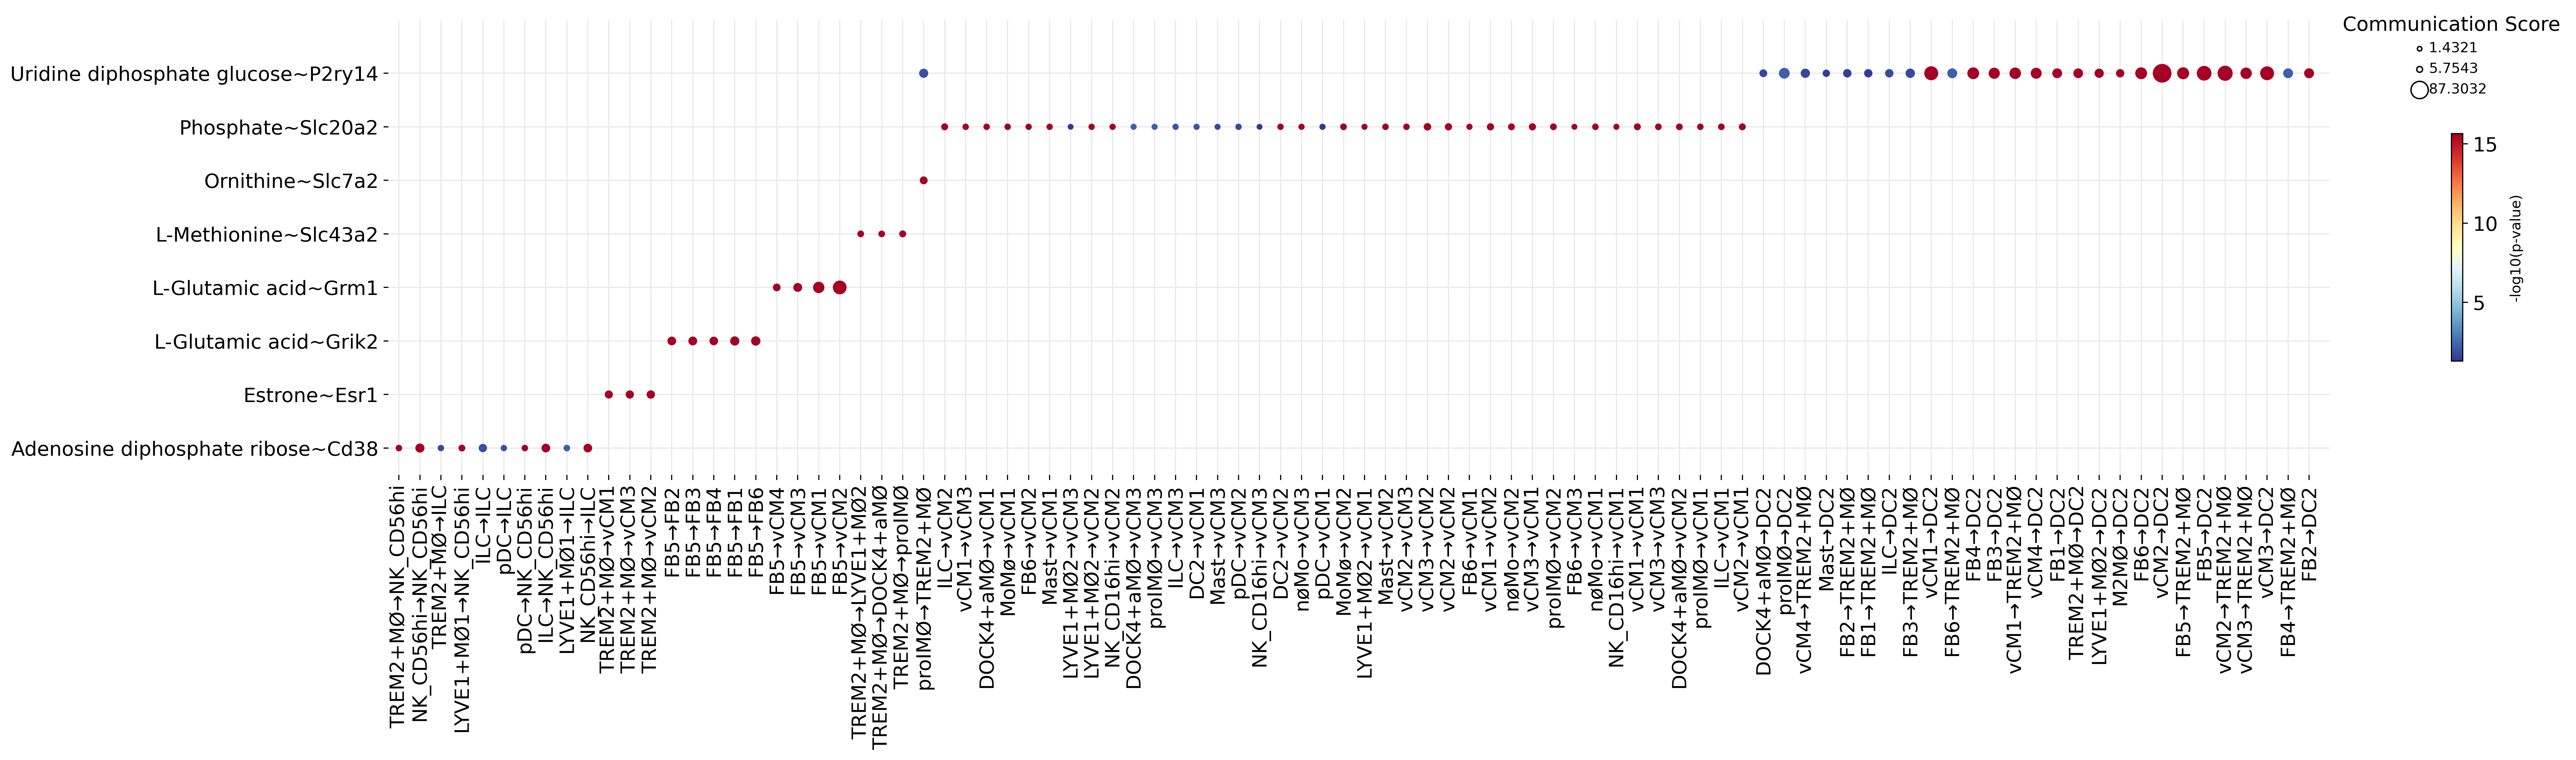

In [20]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'RdYlBu_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

- Visualization of the communication flow from sender metabolite to sensor in receiver

[March 11, 2024 16:36:16]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

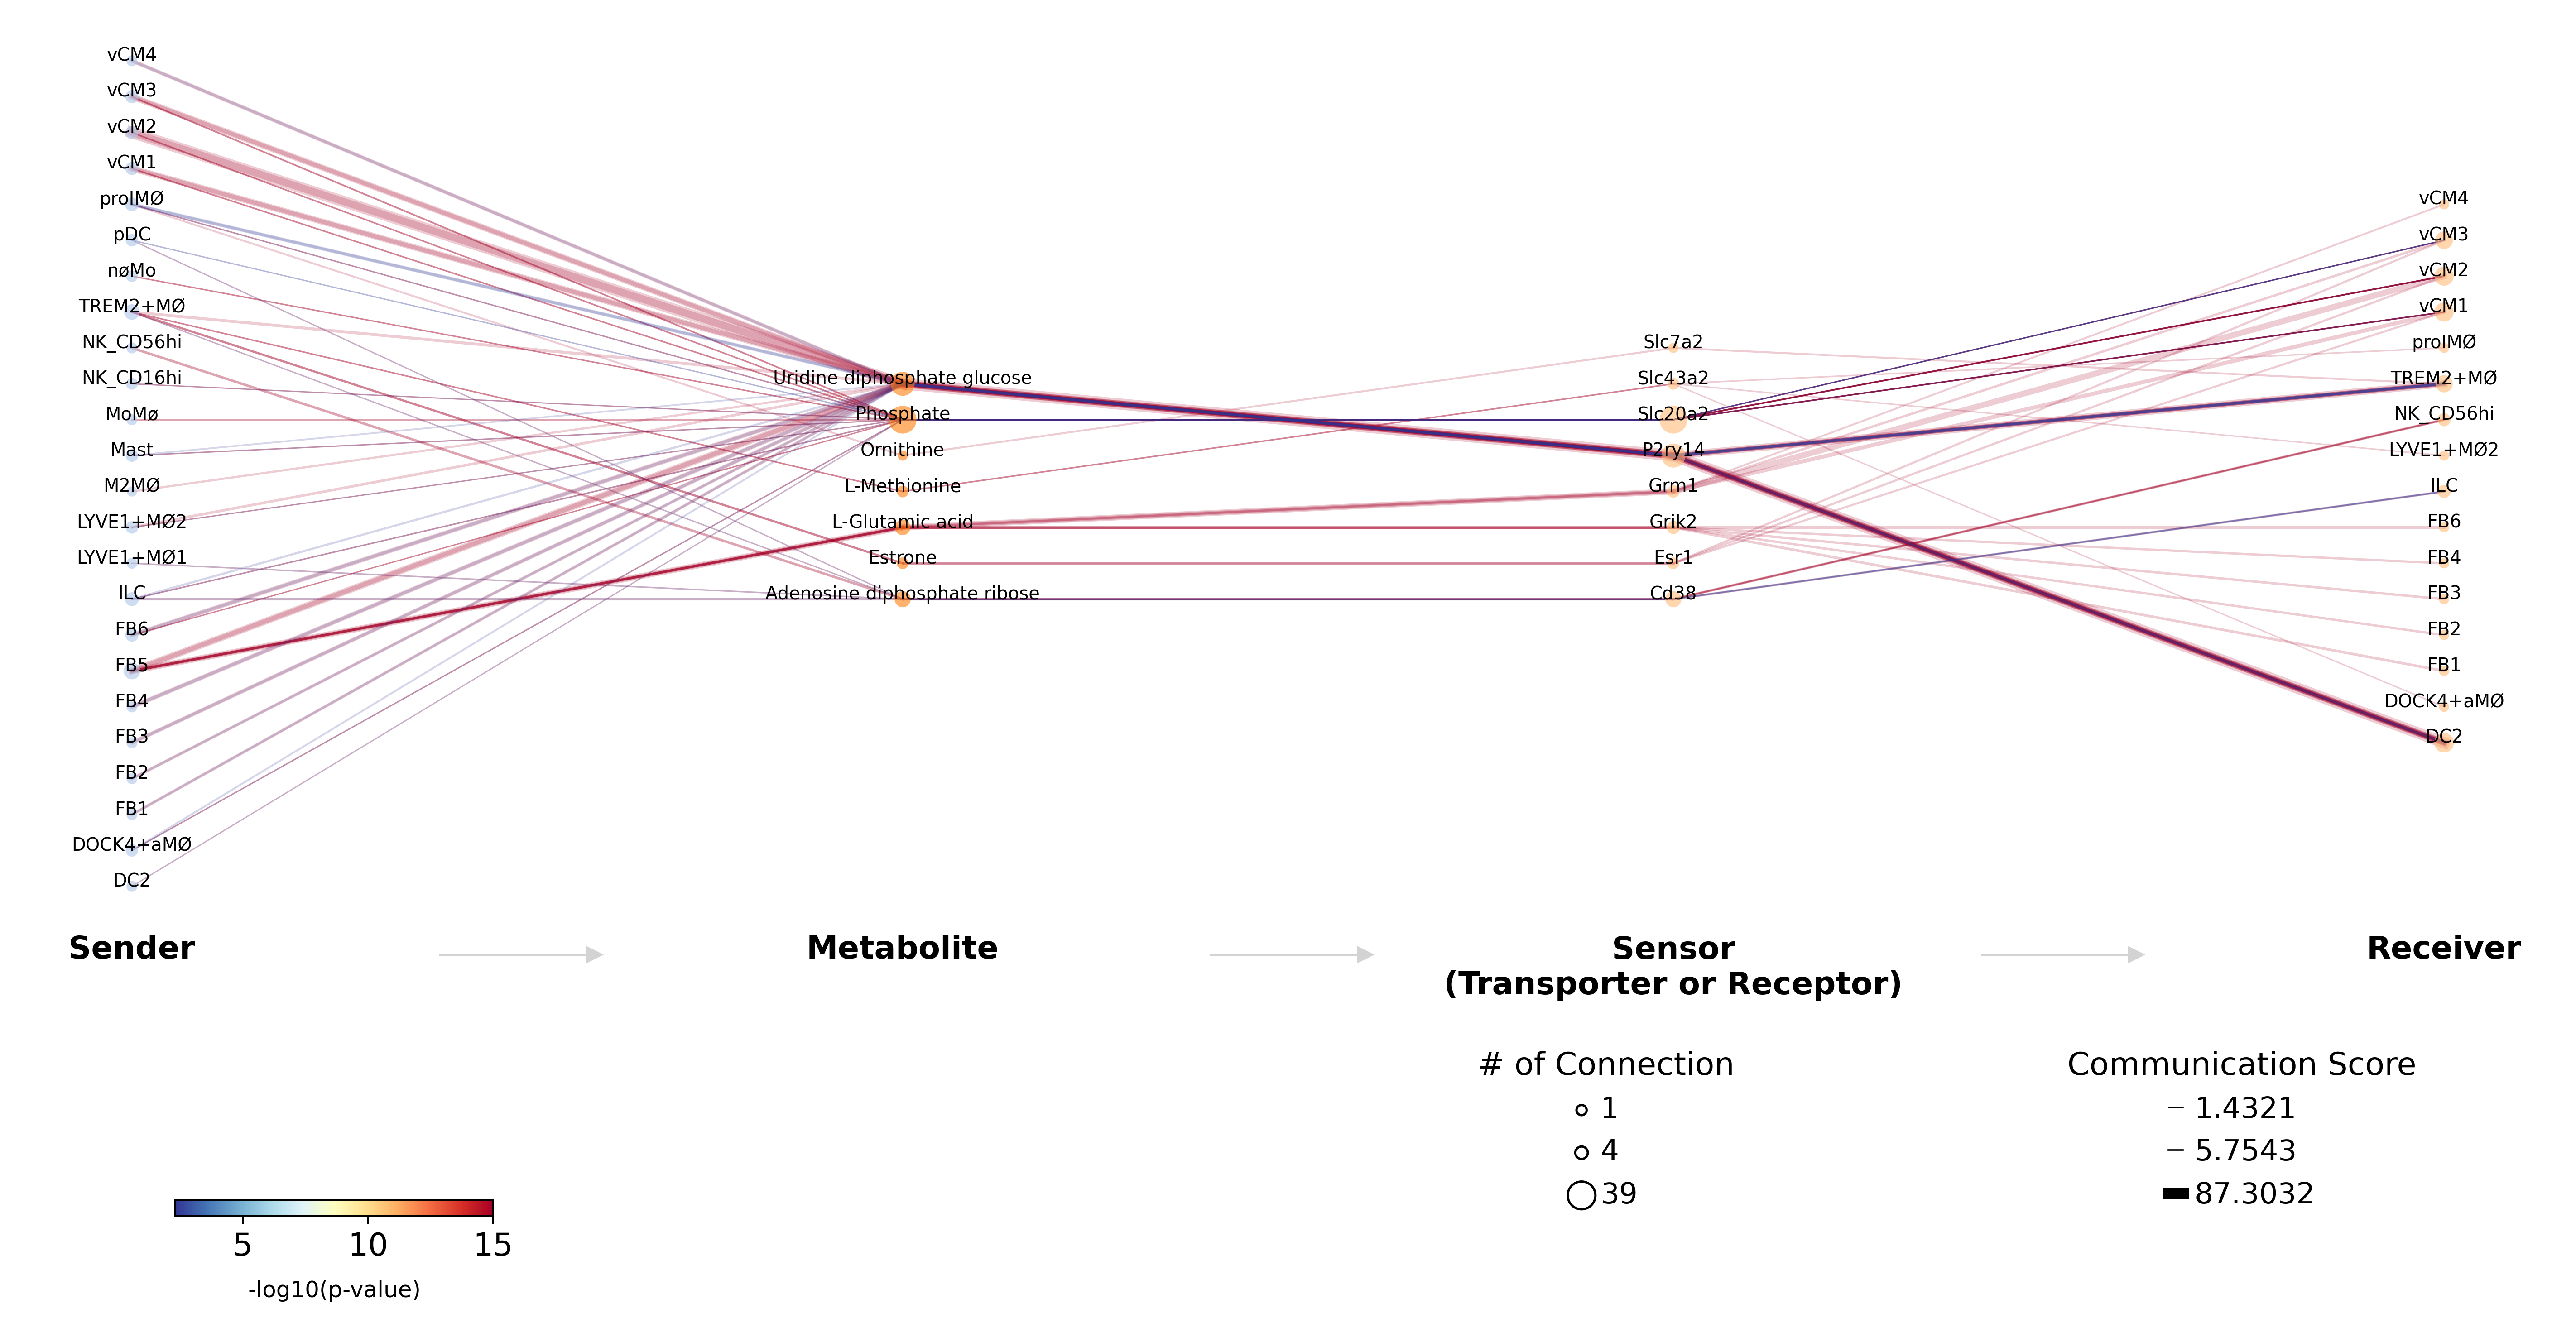

In [23]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = (20,10),
                node_cmap = 'tab20',
                line_cmap = 'RdYlBu_r',
                line_vmin = None,
                line_vmax = 15,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[March 11, 2024 16:36:42]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

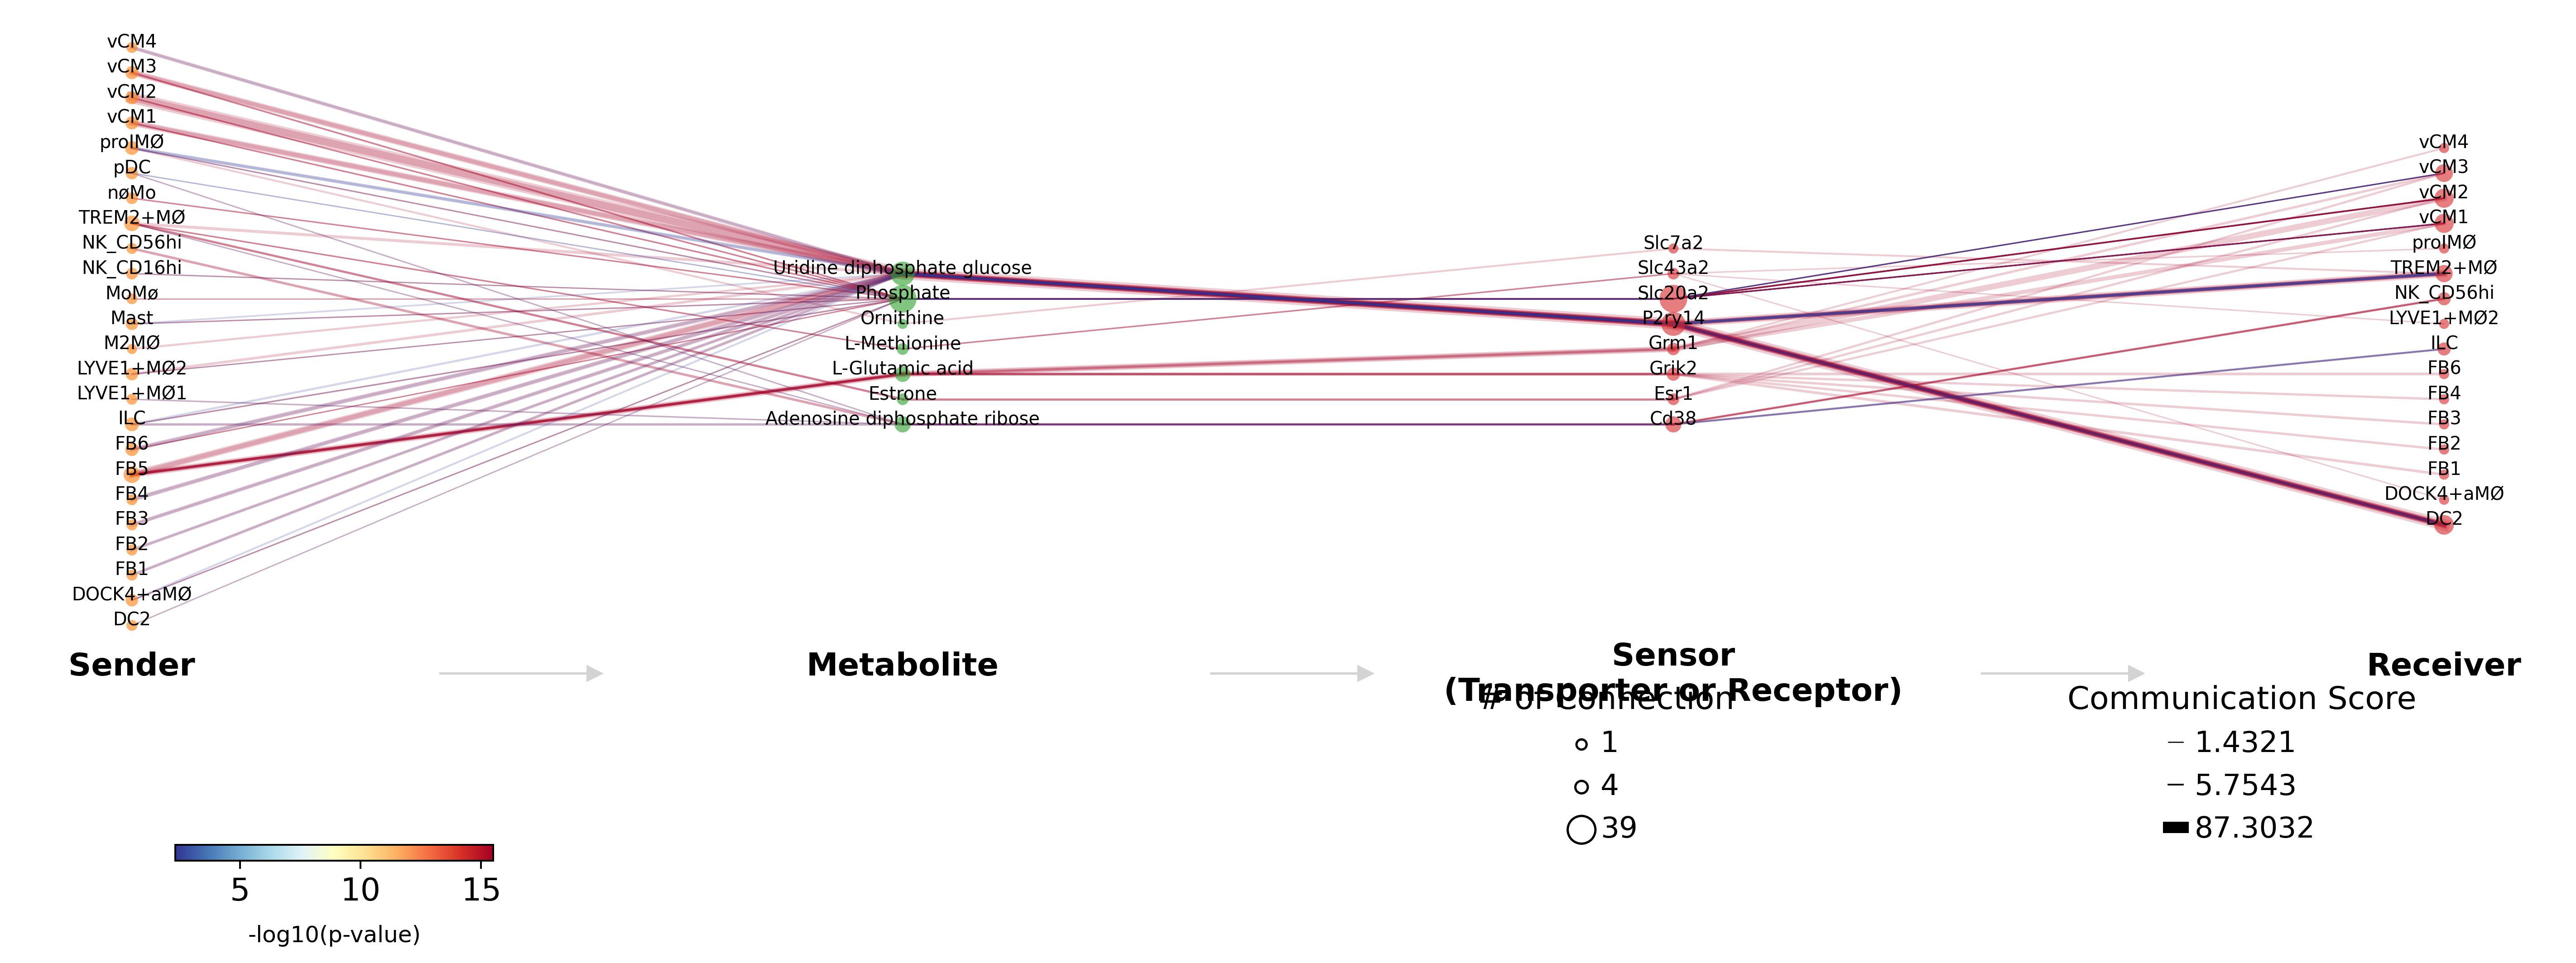

In [24]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = True,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = (20,7),
                node_cmap = 'tab10',
                line_cmap = 'RdYlBu_r',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

- Visualization of the metabolite level or sensor expression in cell groups

[March 11, 2024 16:36:51]: Warnings: no sensors to plot
[March 11, 2024 16:36:51]: Find metabolites ['Estrone', 'L-Methionine', 'Uridine diphosphate glucose', 'Phosphate', 'Adenosine diphosphate ribose', 'Ornithine', 'L-Glutamic acid'] to plot violin


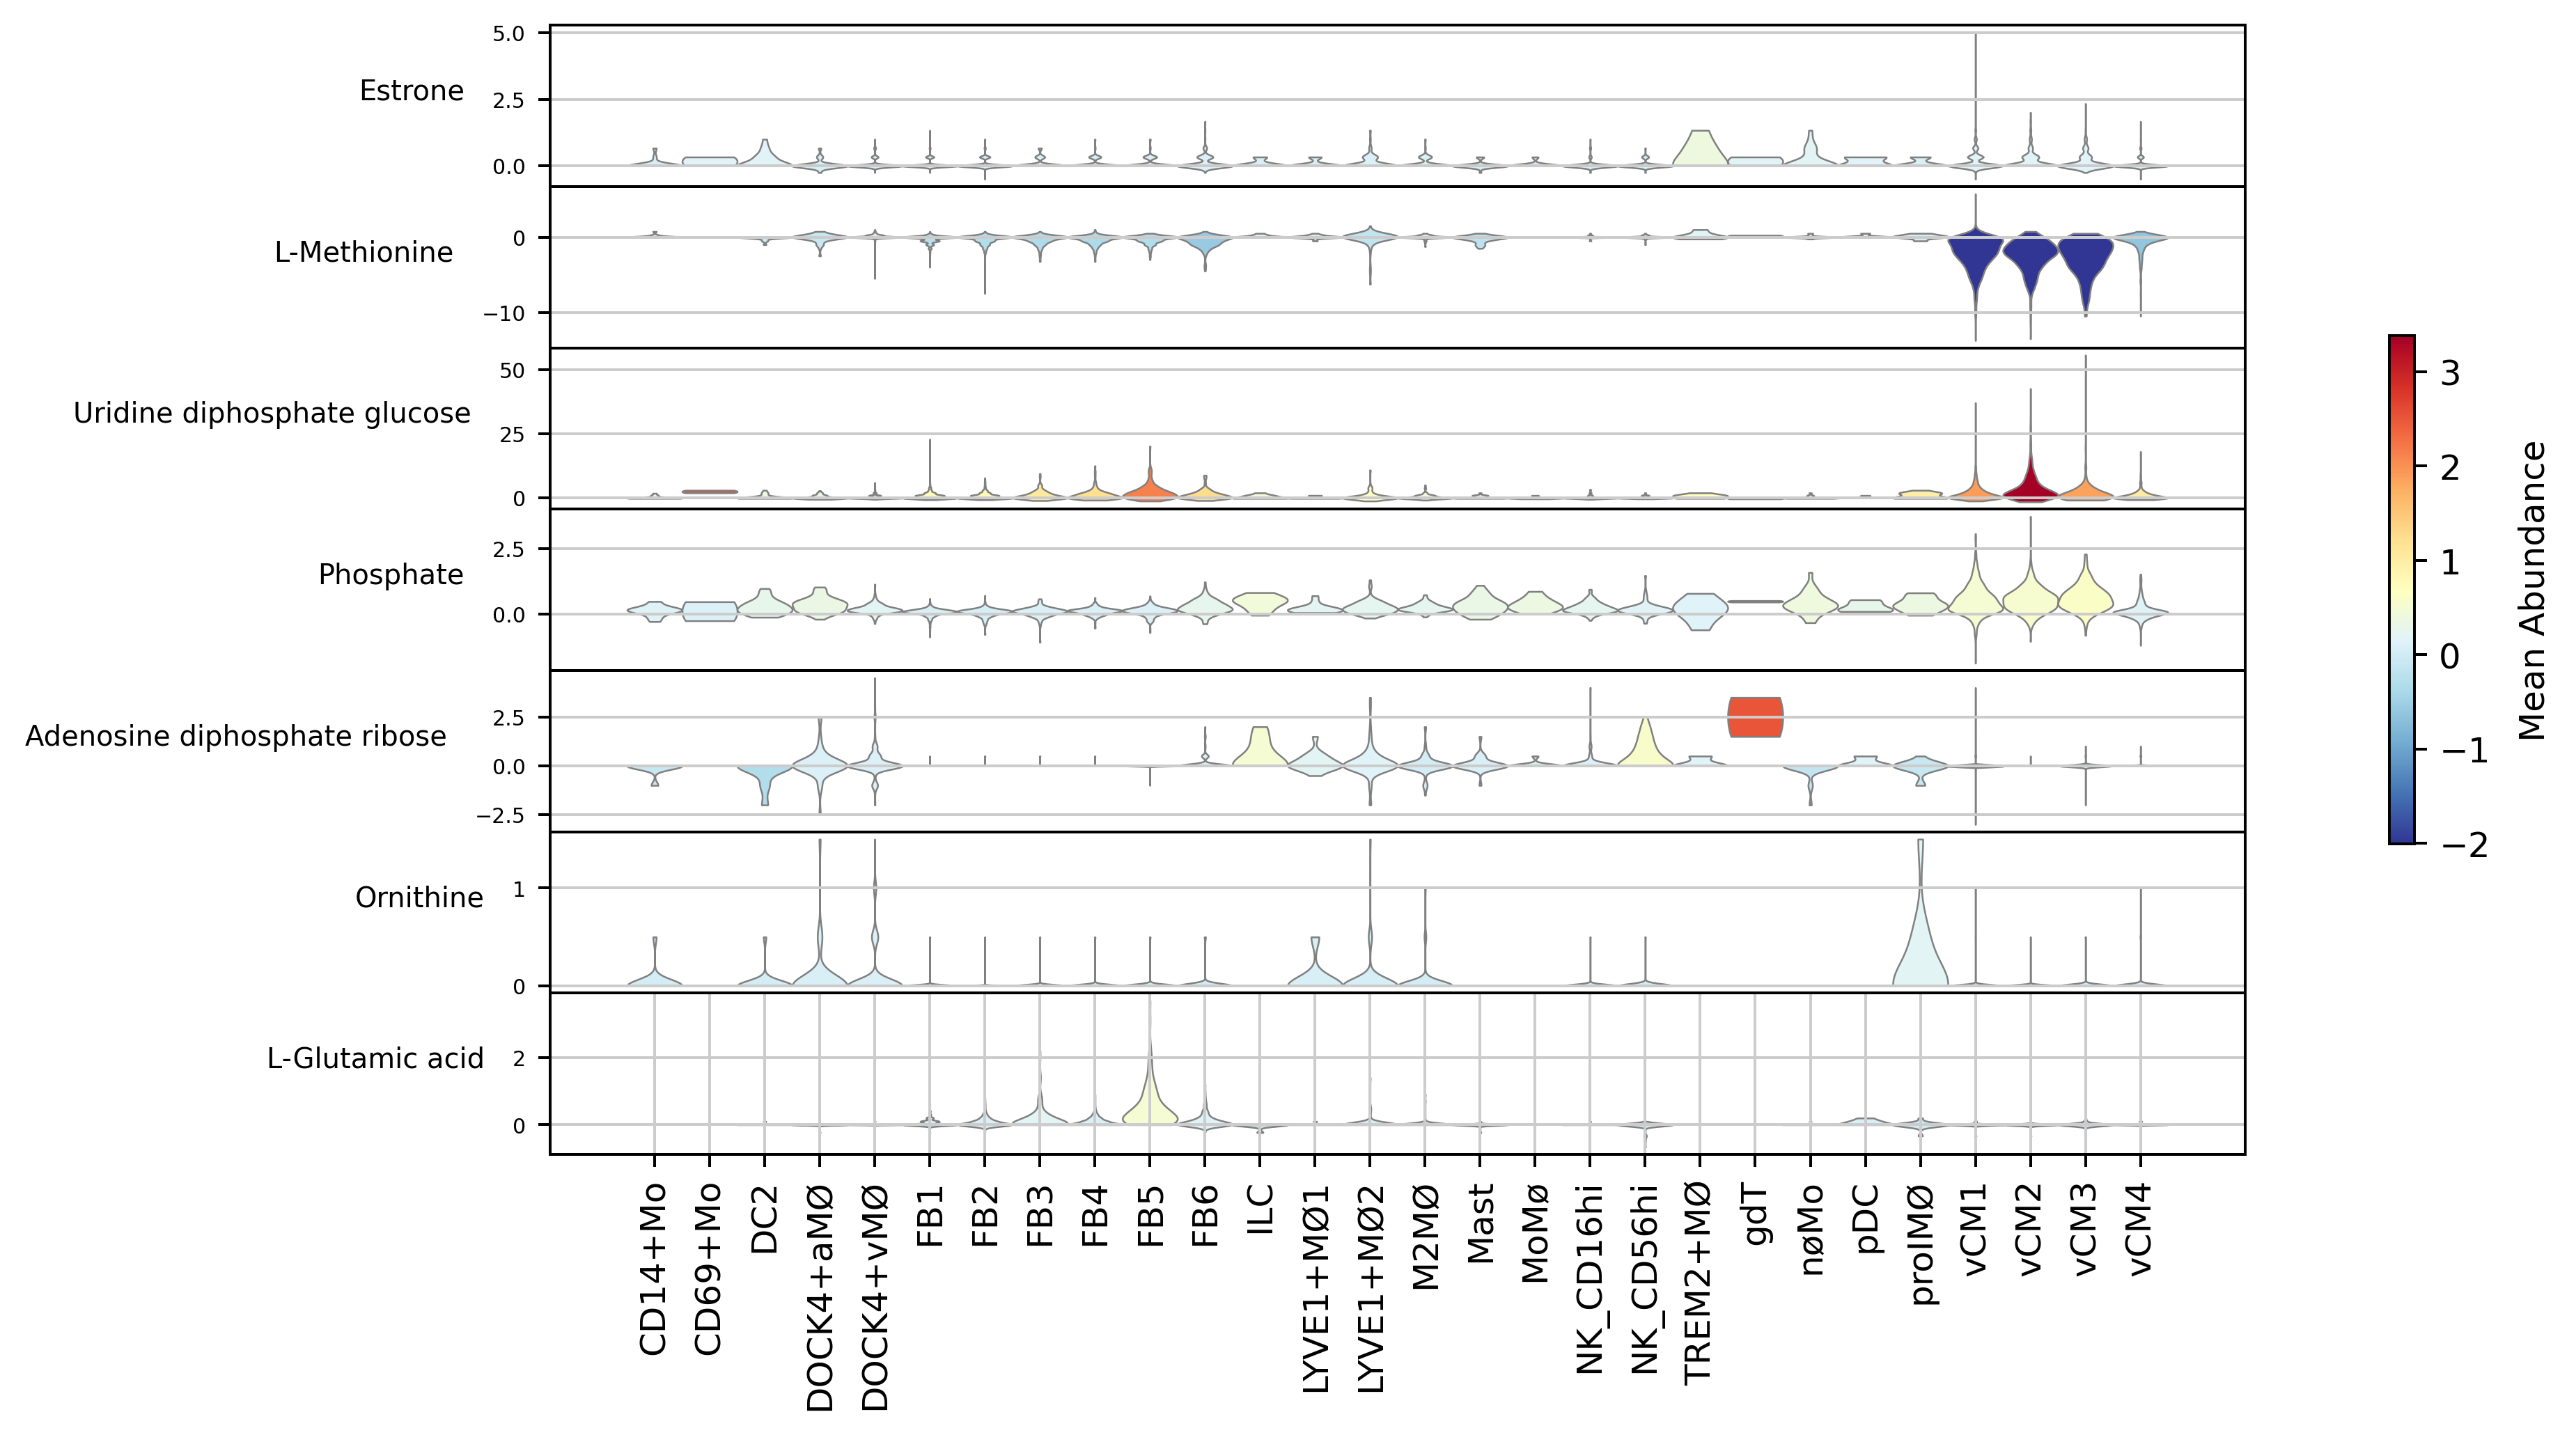

In [25]:
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:10], ## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdYlBu_r',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )

[March 11, 2024 16:37:09]: Find genes Index(['P2ry14', 'Cd38', 'Slc20a2', 'Slc7a2', 'Esr1', 'Grm1', 'Grik2',
       'Slc43a2'],
      dtype='object') to plot violin


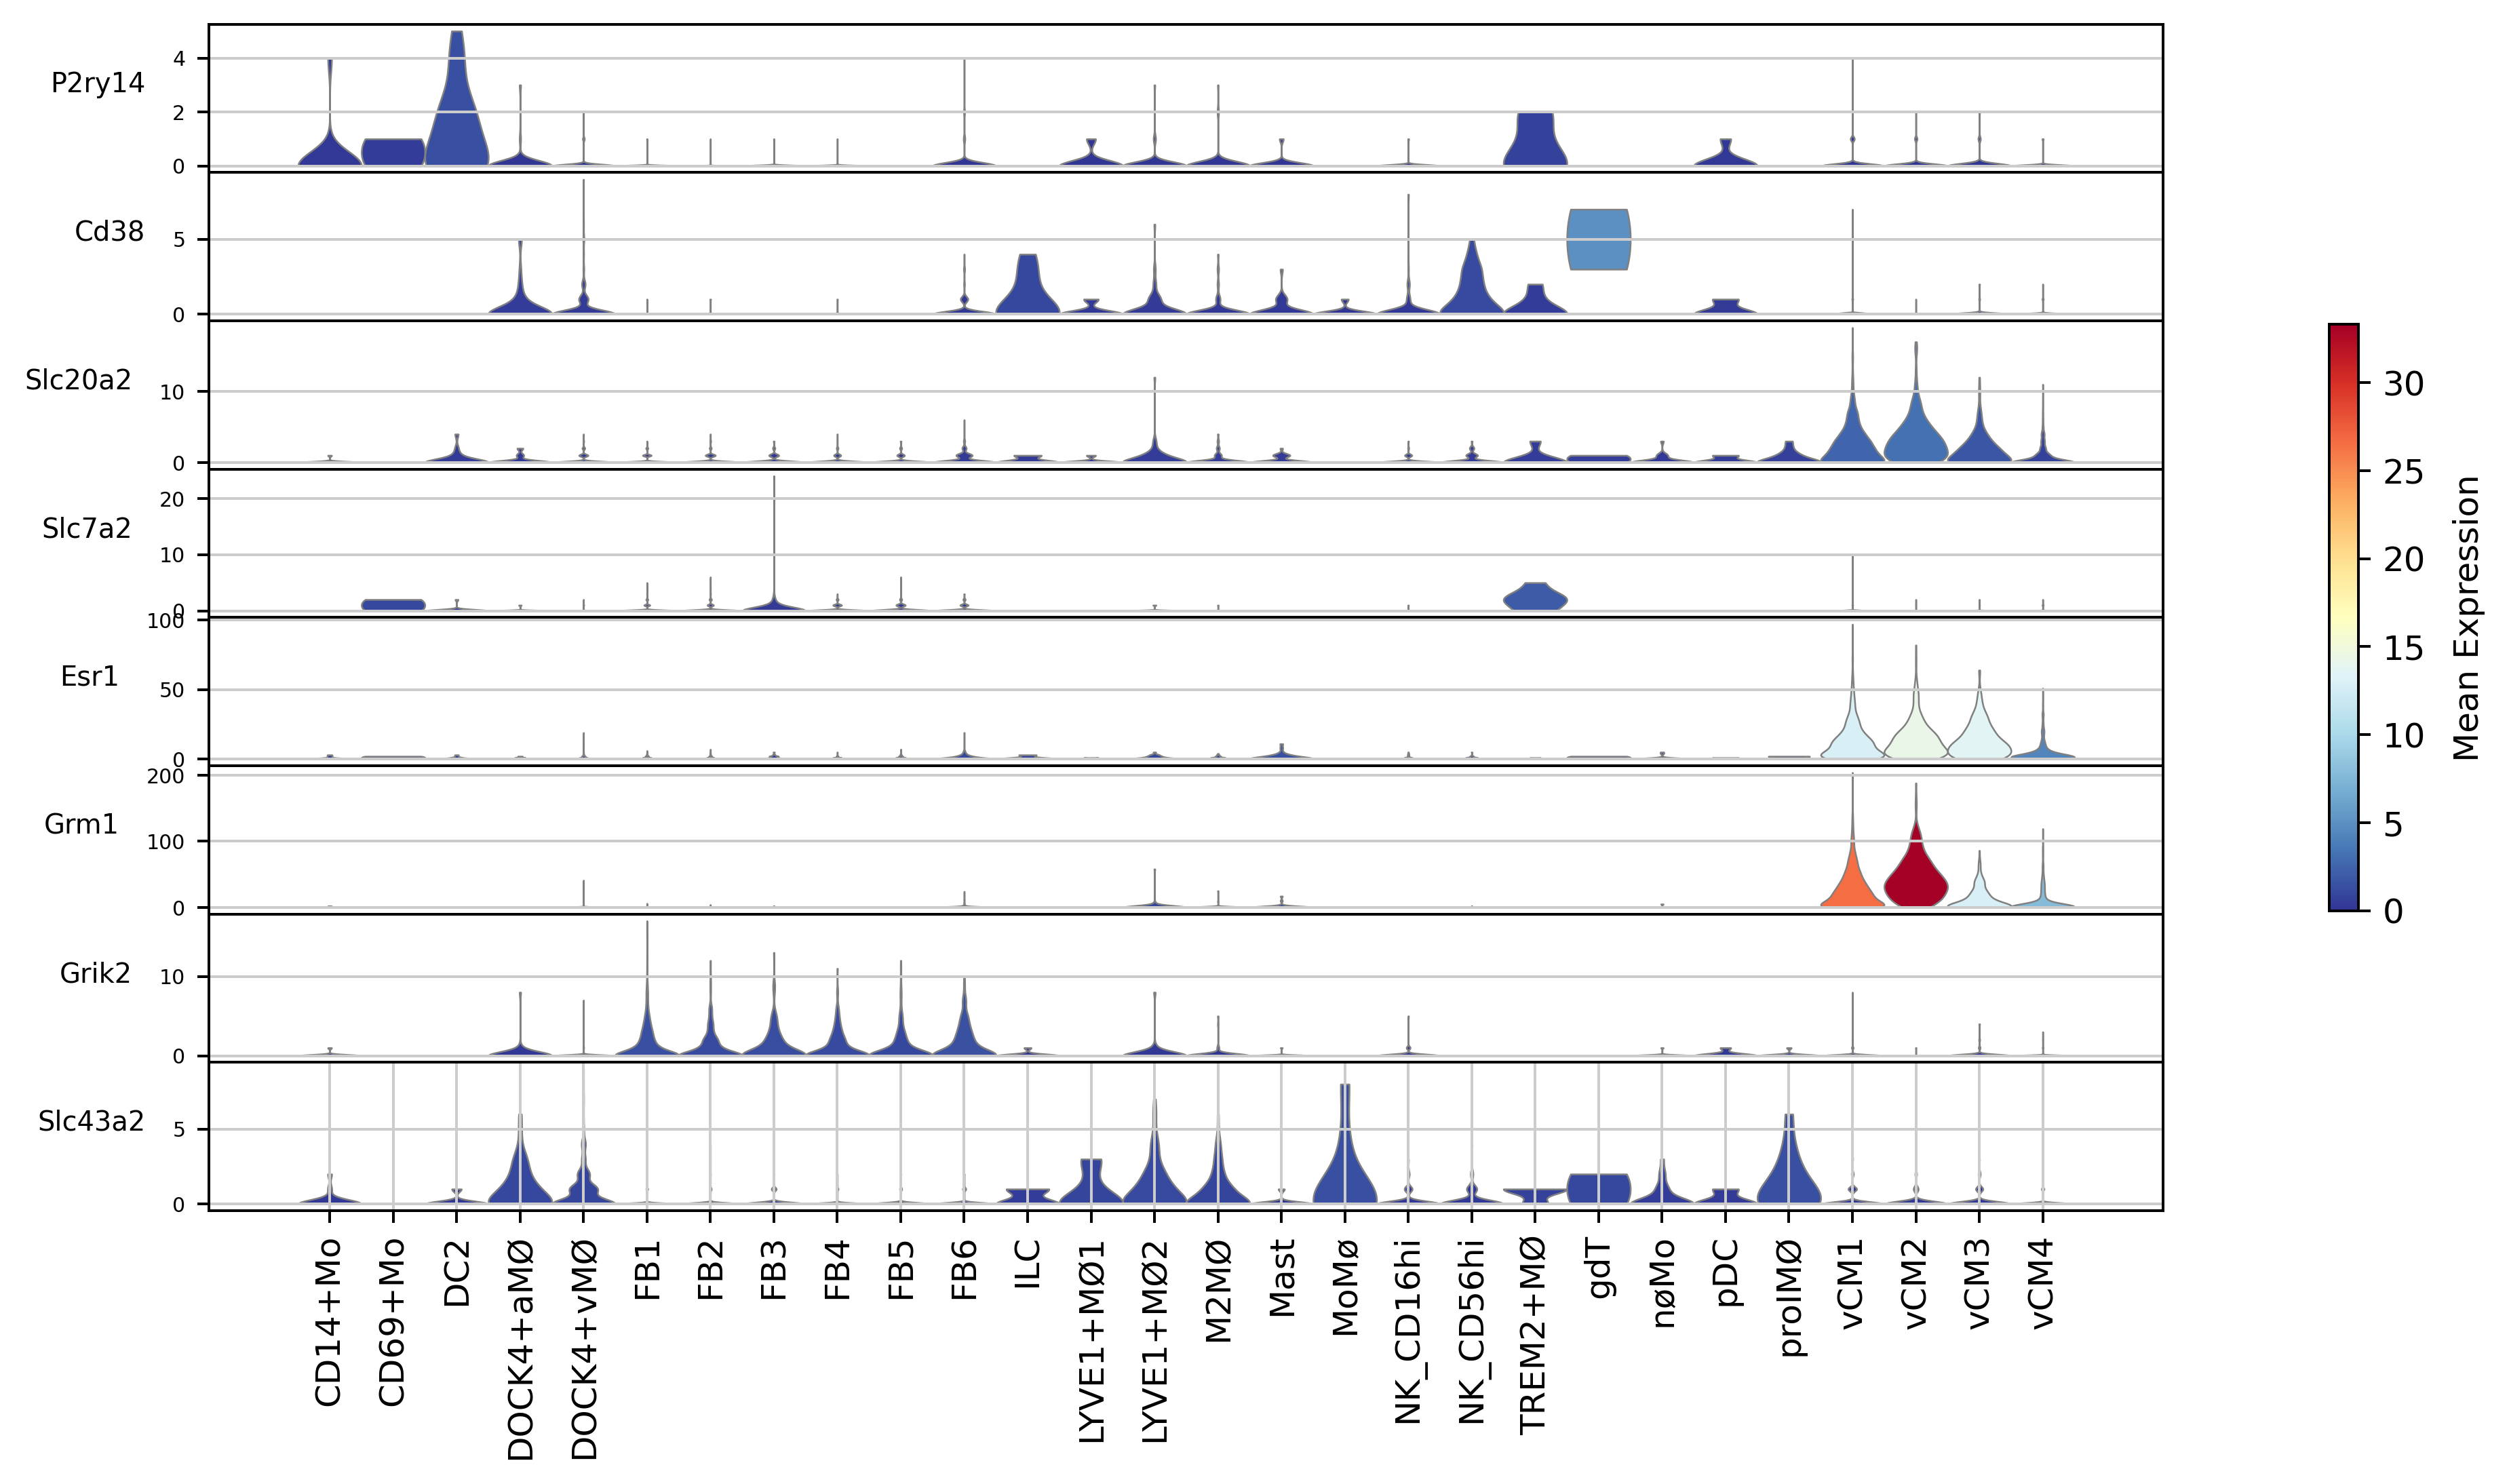

[March 11, 2024 16:37:10]: Warnings: no metabolites to plot


In [26]:
good_sensor = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Sensor'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_sensor[:10],## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdYlBu_r',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )
